In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def multivariate_gaussian(X,mean,cov):
    d=X.shape[1]
    assert d==len(mean)
    if np.isscalar(cov):
        cov=(cov**2)*np.eye(d)
    else:
        assert cov.shape[0]==d and cov.shape[1]==d
    c=(1/np.sqrt((2*np.pi)**d))
    det=np.linalg.det(cov)
    covi=np.linalg.inv(cov)
    mean=np.asarray(mean)
    out=c*np.exp(-0.5*np.matmul(np.matmul((X-mean[np.newaxis,:])[:,np.newaxis,:],covi),
                                (X-mean[np.newaxis,:])[:,:,np.newaxis]))
    return out.squeeze()

def gaussian(t,mu,sigma):
    return (1./np.sqrt(2*np.pi*(sigma**2)))*np.exp(-((t-mu)**2)/(2*(sigma**2)))

In [3]:
gridx,gridy=np.meshgrid(np.linspace(-110,110,num=100),np.linspace(-110,110,num=100))
gridvec = np.concatenate((np.reshape(gridx,(10000,1)),np.reshape(gridy,(10000,1))),1)

In [4]:
mean1=[-20.,30]
mean2=[40.,-50]
cov1=3.*np.array([[120.,70],[100,160]])
cov2=3.*np.array([[130.,10],[10,160]])
N=30

# Two Gaussian distributions
Z1=multivariate_gaussian(gridvec,mean1,cov1).reshape((100,100))
Z2=multivariate_gaussian(gridvec,mean2,cov2).reshape((100,100))

# Data points from the above two distributions
z1=np.random.multivariate_normal(mean1,cov1,(N,))
z2=np.random.multivariate_normal(mean2,cov2,(N,))

/home/xy4cm/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


In [17]:
from sklearn.linear_model import LogisticRegression
# Learn a linear classifier to seperate these two datasets
classifier=LogisticRegression(solver='lbfgs')
classifier.fit(np.concatenate((z1,z2)),
               np.concatenate((np.zeros((z1.shape[0],)),
               np.ones((z2.shape[0],)))))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
# Enforce the weight vector to have unit length
w=classifier.coef_
w/=np.sqrt(np.sum(w**2))

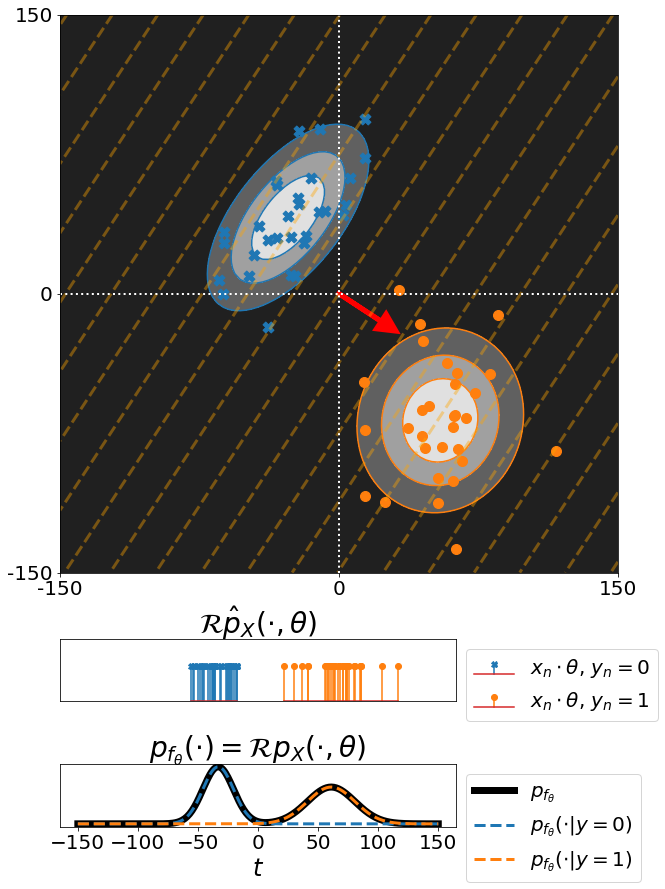

In [20]:
l=20
t=np.linspace(-150,150,301)

fig=plt.figure(figsize=(10,15))
grid = plt.GridSpec(7,7, wspace=.1, hspace=1.)


# ================= First plot ===================
plt.subplot(grid[:5,:])

# Plot two distributions
plt.contourf(gridx+110, gridy+110,Z1+Z2,3,cmap='gray')
plt.contour(gridx+110, gridy+110,Z1,3, colors='C0')
plt.contour(gridx+110, gridy+110,Z2,3, colors='C1')

# Plot data points
plt.scatter(z1[:,0]+110,z1[:,1]+110,marker='X',c='C0',s=120)
plt.scatter(z2[:,0]+110,z2[:,1]+110,marker='o',c='C1',s=100)

# Plot project lines
plt.contour(gridx+110, gridy+110,
            np.matmul(gridvec,w.squeeze()).reshape((100,100)),
            20, colors='orange',linewidths=3,linestyles='--',alpha=.4)



# Plot x and y axis
plt.plot([110,110],[0,220],':w',linewidth=2)
plt.plot([0,220],[110,110],':w',linewidth=2)

# Plot the weight vector
plt.arrow(110,110,
          l*w.squeeze()[0],
          l*w.squeeze()[1],
          color='red',capstyle='projecting',
          head_width=7, head_length=7,linewidth=5)


plt.axis('square')
plt.xticks(np.linspace(0,220,3),[-150,0,150],fontsize=20)
plt.yticks(np.linspace(0,220,3),[-150,0,150],fontsize=20)

# ================= Second plot ===================

# Projections on the weight vector
z1proj=np.matmul(z1,w.squeeze())
z2proj=np.matmul(z2,w.squeeze())

plt.subplot(grid[5,:-2])
# Plot projected data
plt.stem(z1proj,np.ones_like(z1proj)/float(N),markerfmt='X',linefmt='C0-')
plt.stem(z2proj,np.ones_like(z2proj)/float(N),markerfmt='o',linefmt='C1-')

# Labels and ticks
plt.xlim([-150,150])
plt.ylim([0,.06])
plt.xticks([])
plt.yticks(fontsize=20)
plt.yticks([])
plt.title(r'$\mathcal{R}\hat{p}_X(\cdot,\theta)$',fontsize=28)
plt.legend([r'$x_n\cdot\theta$, $y_n=0$',r'$x_n\cdot\theta$, $y_n=1$'],
           fontsize=20,bbox_to_anchor=(1.0, 1.0))

# ================= Third plot ===================

plt.subplot(grid[6,:-2])

# Projected mean and std
mu1=np.matmul(np.asarray(mean1),w.squeeze())
mu2=np.matmul(np.asarray(mean2),w.squeeze())
sigma1=np.sqrt(np.matmul(np.matmul(w,cov1),w.squeeze()))
sigma2=np.sqrt(np.matmul(np.matmul(w,cov2),w.squeeze()))

# Plot projected distributions
plt.plot(t,gaussian(t,mu1,sigma1)+gaussian(t,mu2,sigma2),
         c='k',linewidth=7)
plt.plot(t,gaussian(t,mu1,sigma1),'--',c='C0',linewidth=3)
plt.plot(t,gaussian(t,mu2,sigma2),'--',c='C1',linewidth=3)

# Labels
plt.xticks(fontsize=20)
plt.yticks([])
plt.title(r'$p_{f_\theta}(\cdot)=\mathcal{R}p_X(\cdot,\theta)$',fontsize=28)
plt.xlabel(r'$t$',fontsize=24)
plt.legend([r'$p_{f_\theta}$',r'$p_{f_\theta}(\cdot|y=0)$',
            r'$p_{f_\theta}(\cdot|y=1)$'],fontsize=20,bbox_to_anchor=(1., 1.))

fig.savefig('./linear_classifier.png',transparent=True)
